# Model Evaluations for vaccine data

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
import lightgbm as lgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set(style="whitegrid")

### Load the dataset

In [ ]:
covid_main_df = pd.read_csv('./covidcast_new-1.csv')

In [ ]:
covid_main_df.head()

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,1/7/2021,1000,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,29.288429,30.487852,57.334785,3.244379,2.6382,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,1/7/2021,1003,32.814153,10.189340,1.270183,61.516584,25.179399,51.160278,NaN,28.384842,53.172285,1.199572,NaN,27.532881,23.406516,8.933682,28.864558,82.778220,11.727249
2,1/7/2021,1015,35.621311,14.591271,6.594649,NaN,NaN,54.503711,NaN,37.003522,NaN,3.890709,NaN,NaN,20.974363,NaN,NaN,NaN,13.255336
3,1/7/2021,1051,40.453615,14.164503,3.320922,68.718538,19.438763,54.948755,NaN,37.637900,67.550815,3.284647,NaN,30.223647,20.009477,7.570250,26.494057,86.587182,13.823318
4,1/7/2021,1069,39.228766,10.103564,0.288897,59.961036,23.065494,60.118290,NaN,36.156326,55.995745,1.881970,NaN,30.806929,16.574756,12.916249,24.747620,85.825453,10.258936


### Explore the dataset

In [ ]:
print("Shape: ", covid_main_df.shape)

In [ ]:
print(covid_main_df.dtypes)

time_value                               object
geo_value                                 int64
smoothed_wspent_time_1d                 float64
smoothed_wtested_14d                    float64
smoothed_wpublic_transit_1d             float64
smoothed_wworried_become_ill            float64
smoothed_wvaccine_likely_govt_health    float64
smoothed_wshop_1d                       float64
smoothed_wtested_positive_14d           float64
smoothed_wwork_outside_home_1d          float64
smoothed_wothers_masked                 float64
smoothed_wcli                           float64
smoothed_wcovid_vaccinated              float64
smoothed_wvaccine_likely_friends        float64
smoothed_wrestaurant_1d                 float64
smoothed_wvaccine_likely_politicians    float64
smoothed_wvaccine_likely_who            float64
smoothed_wwearing_mask                  float64
smoothed_wlarge_event_1d                float64
dtype: object


In [ ]:
covid_main_df.describe()

,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
count,25626.000000,25066.000000,24688.000000,25066.000000,22515.000000,21257.000000,25066.000000,3994.000000,25066.000000,22097.000000,25481.000000,23024.000000,21366.000000,25066.000000,21123.000000,21270.000000,21985.000000,25066.000000
mean,30022.116717,31.899631,13.120482,2.891016,68.690158,31.117297,53.524201,17.250770,33.999334,81.330137,1.055272,13.674725,34.275744,15.422098,10.100442,36.036825,91.912426,8.514499
std,15464.317094,6.038189,4.640677,2.661727,5.684796,6.641353,5.625381,7.419522,6.310551,12.676522,0.694818,6.665828,5.137006,6.014144,3.353021,7.192531,5.103774,4.269184
min,1000.000000,11.685945,2.144153,0.095057,40.062171,11.408837,32.682451,1.548609,11.041209,22.668564,0.000000,0.891041,15.283547,0.367614,1.256728,13.241941,58.270015,0.274725
25%,17113.000000,27.811878,9.890346,1.565133,65.117334,26.385056,49.588164,11.616797,29.658307,75.032420,0.560933,8.333788,30.858041,10.896965,7.709210,30.833044,89.285249,5.254783
50%,33005.000000,31.685359,12.451805,2.384280,69.024887,30.788040,53.015007,16.530456,33.731881,85.196143,0.942783,12.773208,34.188723,15.375892,9.852045,35.865667,93.220612,7.993092
75%,42077.000000,35.744053,15.601016,3.461986,72.587625,35.415755,57.217082,22.153012,38.154894,90.995163,1.436505,18.000759,37.691155,19.462221,12.118213,41.051398,95.717480,11.135571
max,56025.000000,58.805310,40.974146,36.015469,93.900646,56.214259,83.593709,46.644291,59.786678,99.373646,5.123363,45.466215,63.411506,51.142119,28.285788,62.468991,99.732673,33.337252


In [ ]:
covid_main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25626 entries, 0 to 25625
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   time_value                            25626 non-null  object 
 1   geo_value                             25626 non-null  int64  
 2   smoothed_wspent_time_1d               25066 non-null  float64
 3   smoothed_wtested_14d                  24688 non-null  float64
 4   smoothed_wpublic_transit_1d           25066 non-null  float64
 5   smoothed_wworried_become_ill          22515 non-null  float64
 6   smoothed_wvaccine_likely_govt_health  21257 non-null  float64
 7   smoothed_wshop_1d                     25066 non-null  float64
 8   smoothed_wtested_positive_14d         3994 non-null   float64
 9   smoothed_wwork_outside_home_1d        25066 non-null  float64
 10  smoothed_wothers_masked               22097 non-null  float64
 11  smoothed_wcli  

### Exploratory Data Analysis

In [ ]:
print("\nMissing values count:")
missing_values = covid_main_df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values count:
smoothed_wspent_time_1d                   560
smoothed_wtested_14d                      938
smoothed_wpublic_transit_1d               560
smoothed_wworried_become_ill             3111
smoothed_wvaccine_likely_govt_health     4369
smoothed_wshop_1d                         560
smoothed_wtested_positive_14d           21632
smoothed_wwork_outside_home_1d            560
smoothed_wothers_masked                  3529
smoothed_wcli                             145
smoothed_wcovid_vaccinated               2602
smoothed_wvaccine_likely_friends         4260
smoothed_wrestaurant_1d                   560
smoothed_wvaccine_likely_politicians     4503
smoothed_wvaccine_likely_who             4356
smoothed_wwearing_mask                   3641
smoothed_wlarge_event_1d                  560
dtype: int64


In [ ]:
print("\nMissing values percentage:")
missing_percentage = (covid_main_df.isnull().sum() / len(covid_main_df)) * 100
print(missing_percentage[missing_percentage > 0])


Missing values percentage:
smoothed_wspent_time_1d                  2.185281
smoothed_wtested_14d                     3.660345
smoothed_wpublic_transit_1d              2.185281
smoothed_wworried_become_ill            12.140014
smoothed_wvaccine_likely_govt_health    17.049091
smoothed_wshop_1d                        2.185281
smoothed_wtested_positive_14d           84.414267
smoothed_wwork_outside_home_1d           2.185281
smoothed_wothers_masked                 13.771170
smoothed_wcli                            0.565832
smoothed_wcovid_vaccinated              10.153750
smoothed_wvaccine_likely_friends        16.623742
smoothed_wrestaurant_1d                  2.185281
smoothed_wvaccine_likely_politicians    17.571997
smoothed_wvaccine_likely_who            16.998361
smoothed_wwearing_mask                  14.208226
smoothed_wlarge_event_1d                 2.185281
dtype: float64


#### Visualizations

In [ ]:
def plot_histograms(dataframe, columns, rows=3, cols=3, figsize=(18, 14)):
    plt.figure(figsize=figsize)
    for i, column in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        plt.hist(dataframe[column].dropna(), bins=30, alpha=0.7)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# Select numerical columns (excluding ID or date columns)
numerical_columns = covid_main_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'geo_value' in numerical_columns:
    numerical_columns.remove('geo_value')

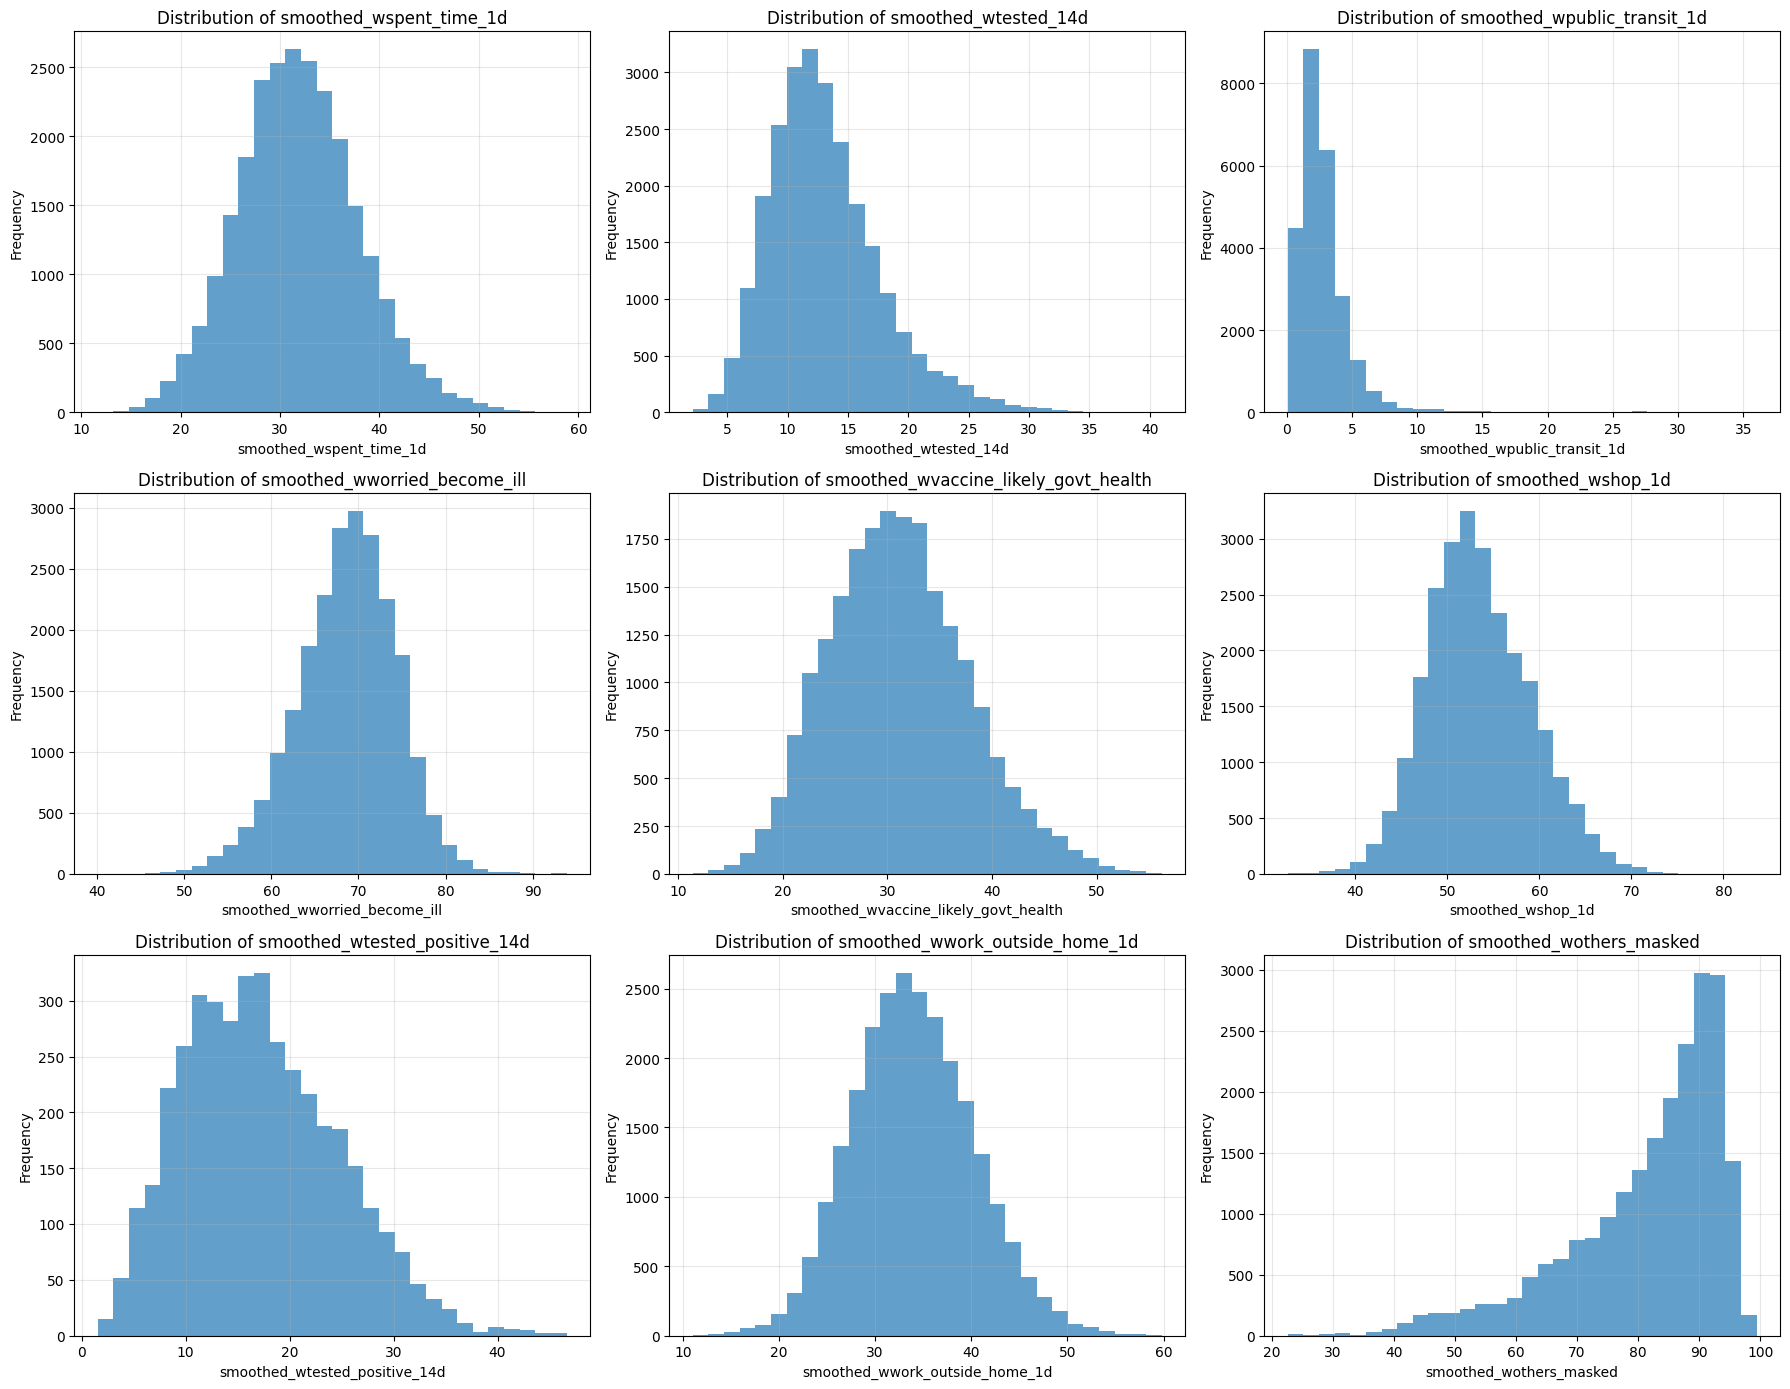

In [ ]:
# Plot histograms for first set of numerical columns
num_plots_per_figure = 9
plot_histograms(covid_main_df, numerical_columns[:num_plots_per_figure])

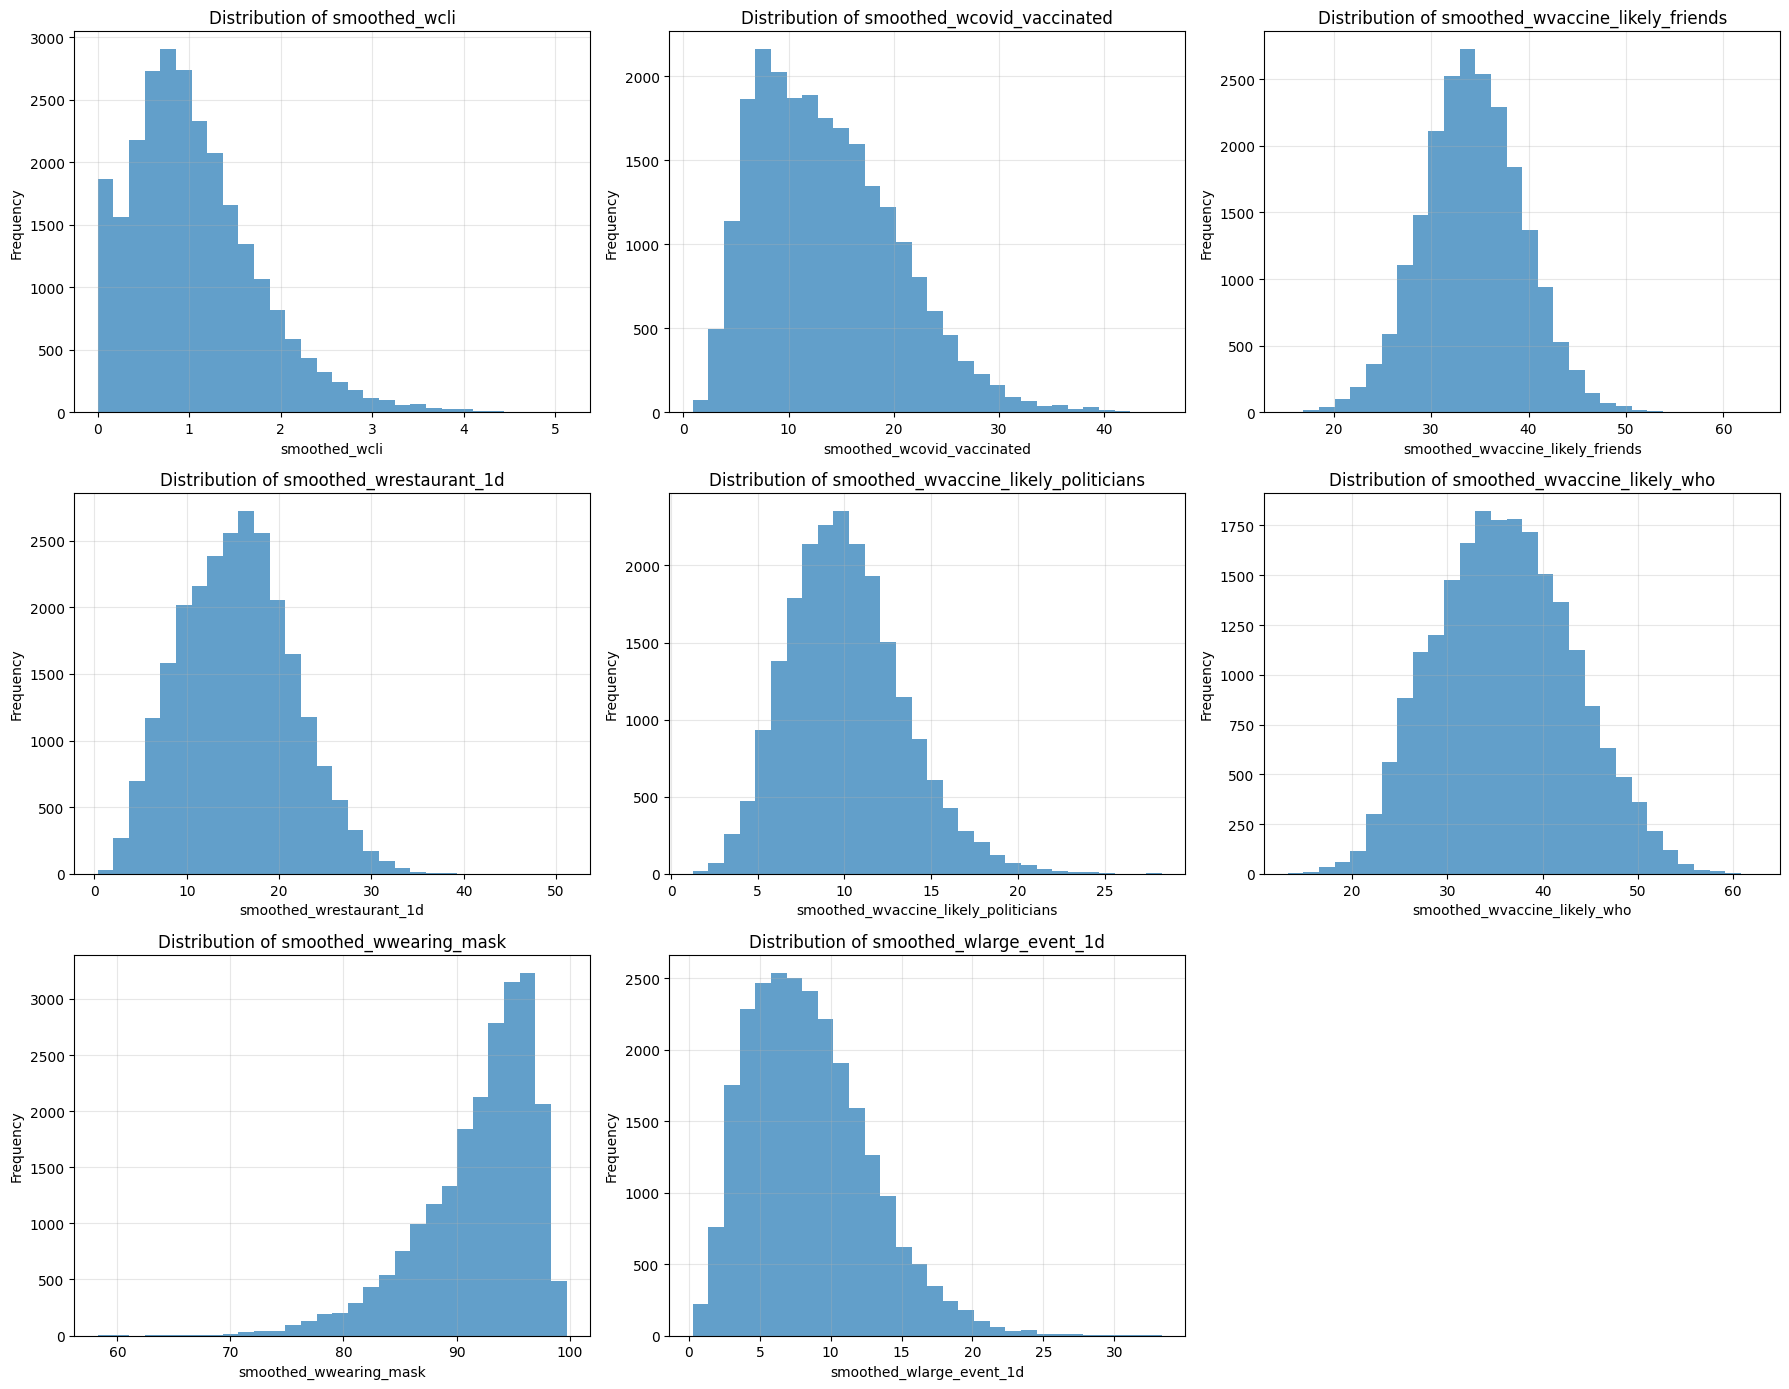

In [ ]:
# Plot histograms for remaining numerical columns if any
if len(numerical_columns) > num_plots_per_figure:
    plot_histograms(covid_main_df, numerical_columns[num_plots_per_figure:])

In [ ]:
def plot_boxplots(dataframe, columns, rows=3, cols=3, figsize=(18, 14)):
    plt.figure(figsize=figsize)
    for i, column in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=dataframe[column].dropna())
        plt.title(f'Boxplot of {column}')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

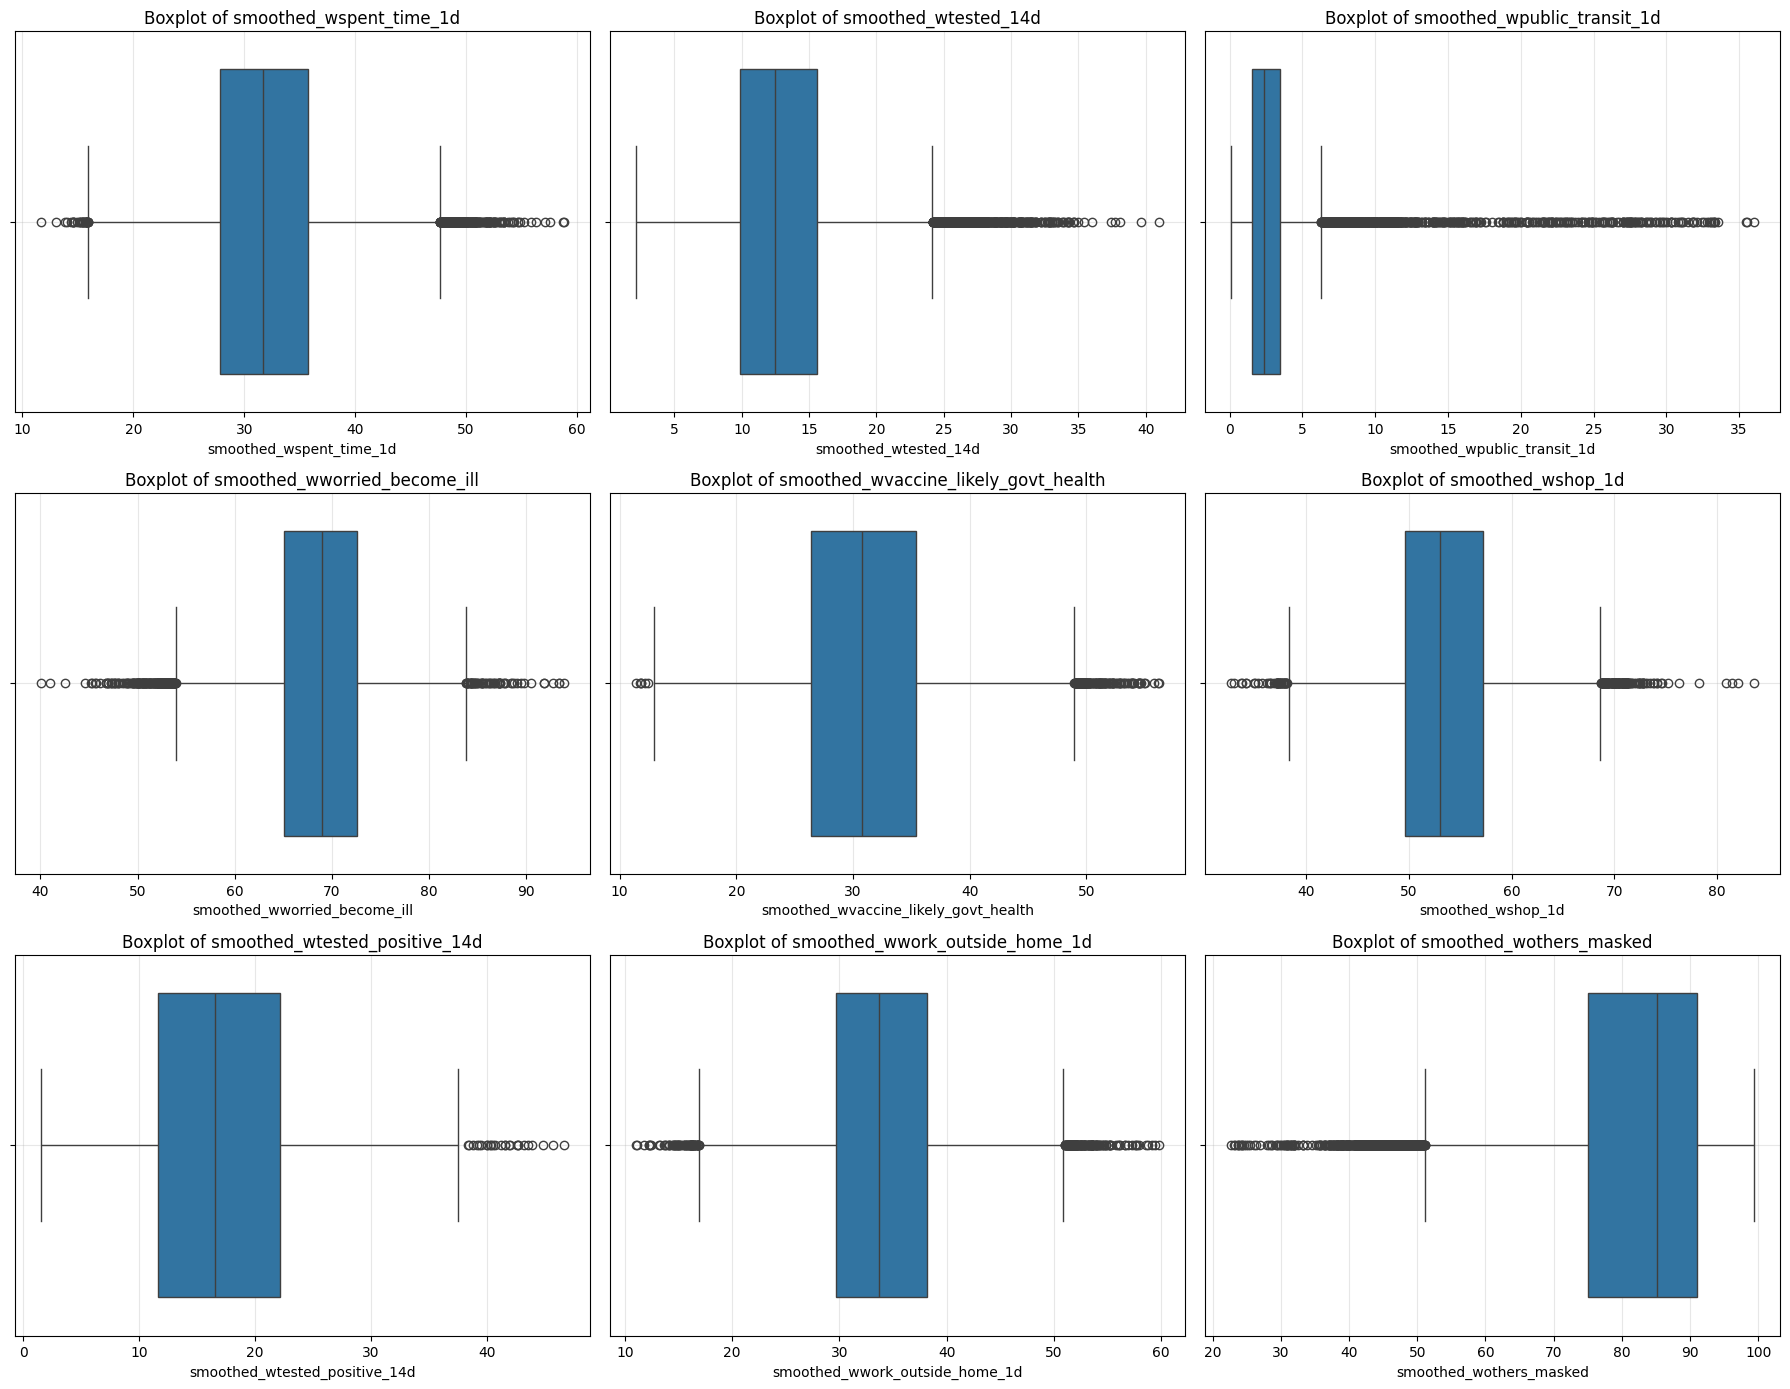

In [ ]:
# Plot boxplots for first set of numerical columns
plot_boxplots(covid_main_df, numerical_columns[:num_plots_per_figure])

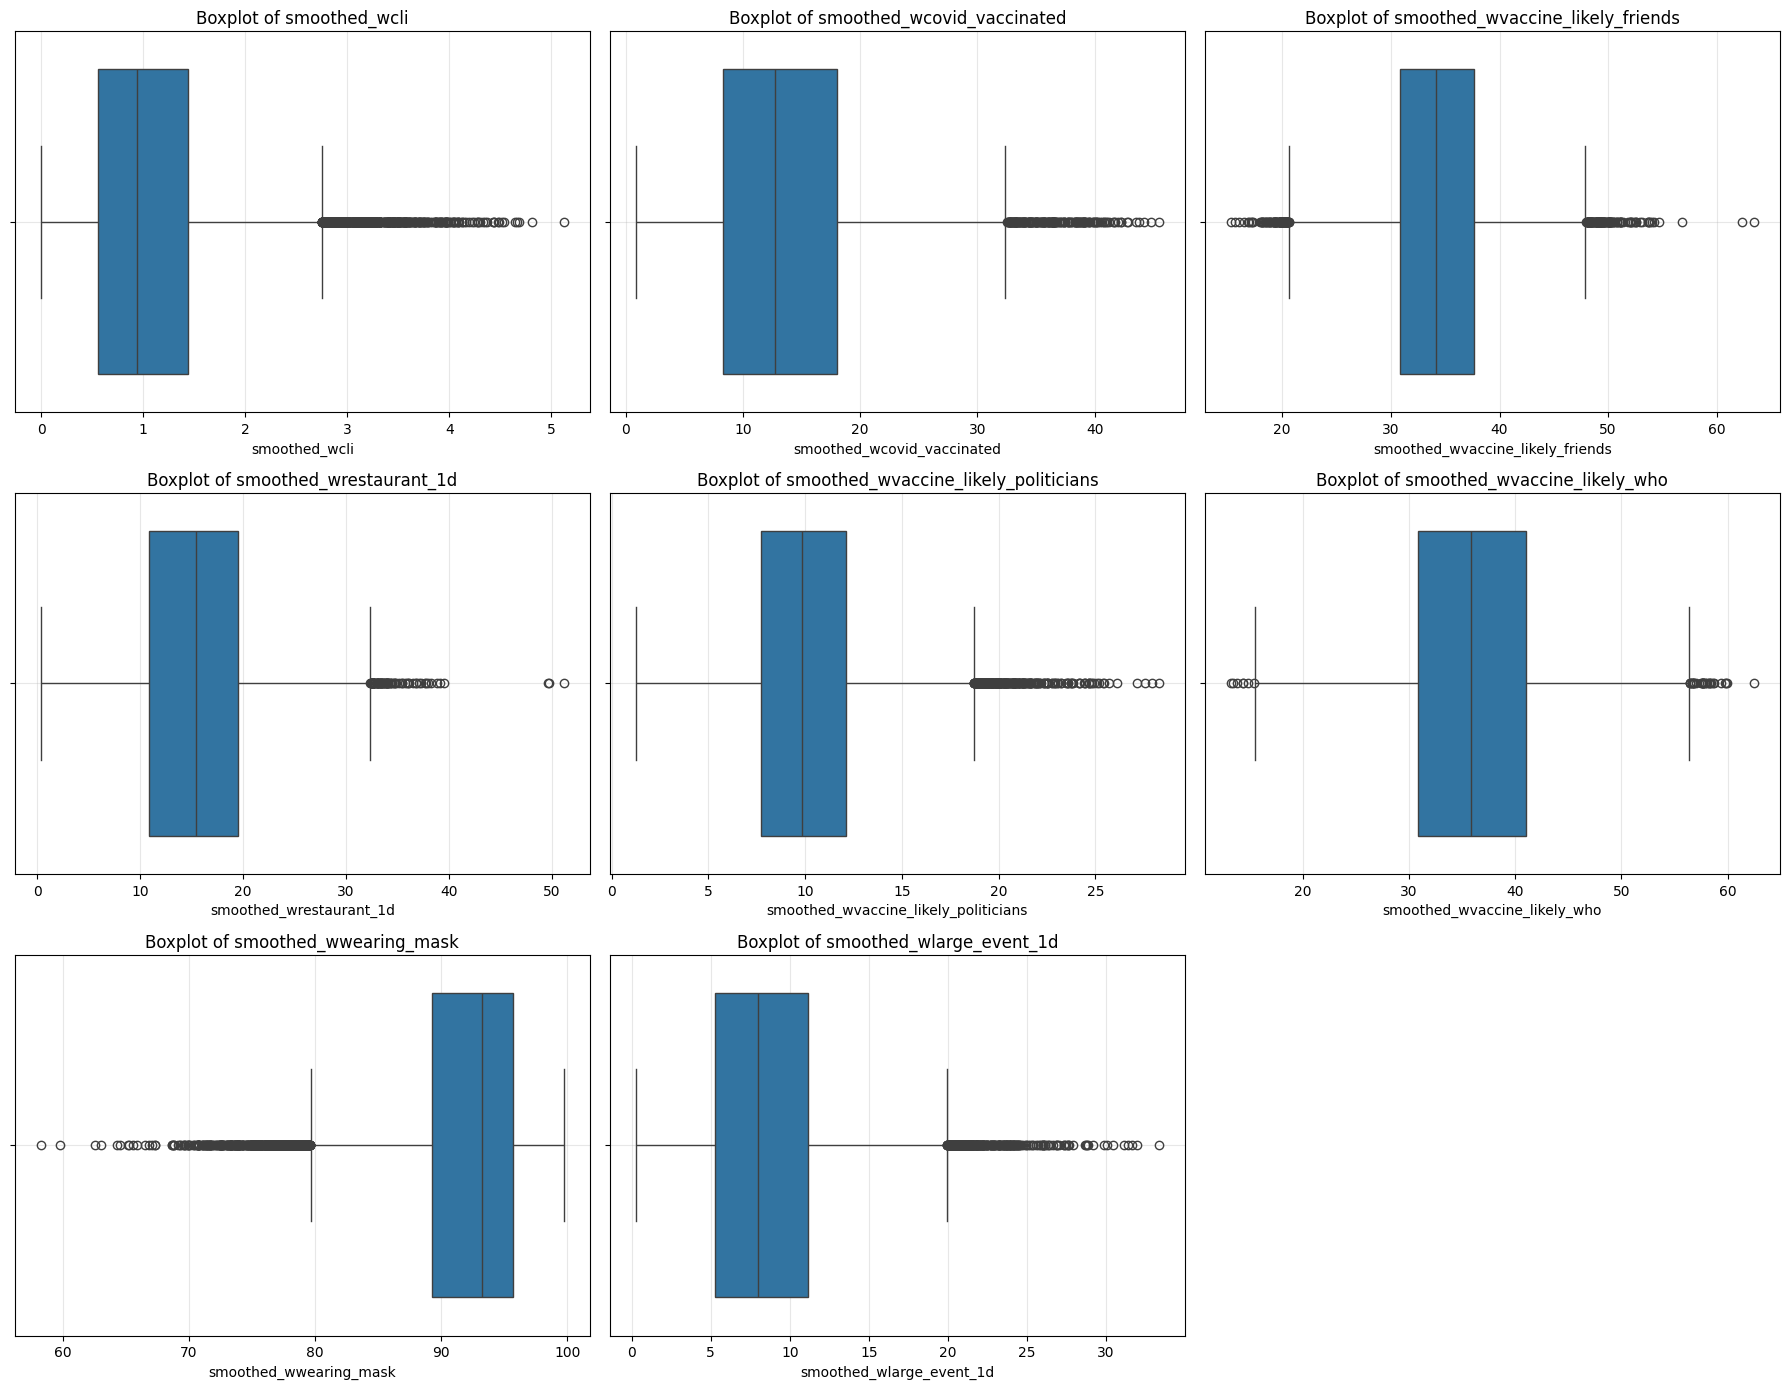

In [ ]:
# Plot boxplots for remaining numerical columns if any
if len(numerical_columns) > num_plots_per_figure:
    plot_boxplots(covid_main_df, numerical_columns[num_plots_per_figure:])

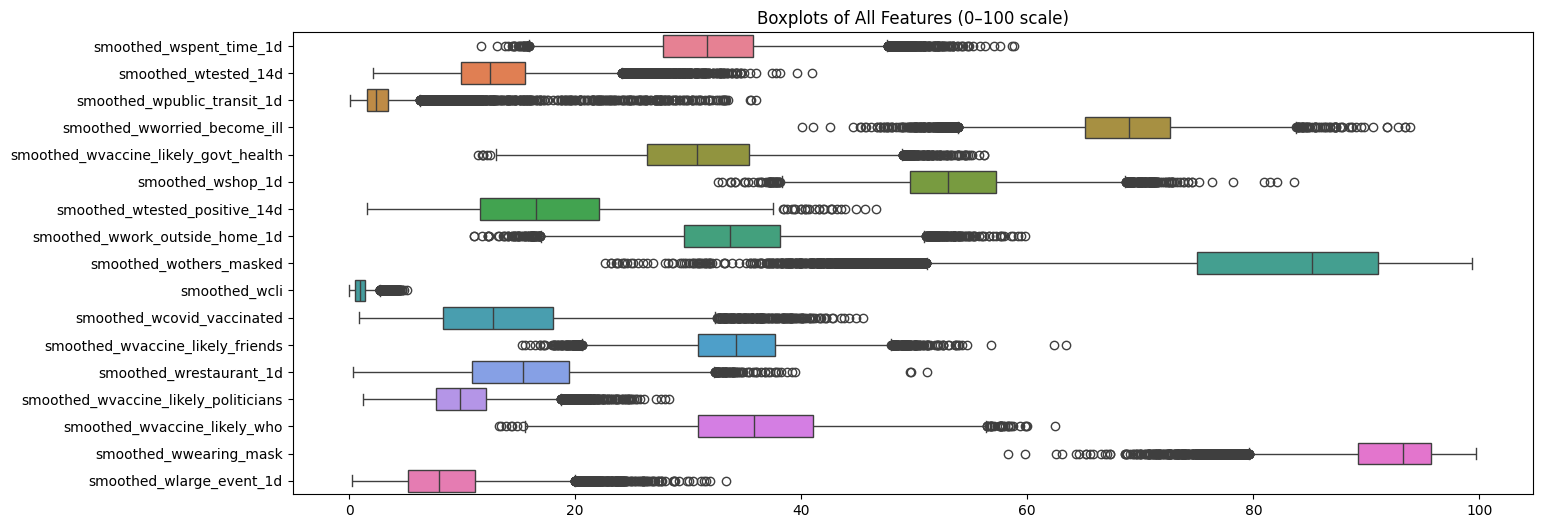

In [ ]:
# Visualize outliers with boxplots
plt.figure(figsize=(16, 6))
sns.boxplot(data=covid_main_df.drop(columns=['time_value', 'geo_value']), orient='h')
plt.title("Boxplots of All Features (0–100 scale)")
plt.show()

#### Feature Analysis

In [ ]:
# Identify feature columns (exclude both targets + metadata)
feature_cols = [col for col in covid_main_df.columns if col not in ['time_value', 'geo_value', 'smoothed_wtested_positive_14d', 'smoothed_wcovid_vaccinated']]
feature_cols

['smoothed_wspent_time_1d',
 'smoothed_wtested_14d',
 'smoothed_wpublic_transit_1d',
 'smoothed_wworried_become_ill',
 'smoothed_wvaccine_likely_govt_health',
 'smoothed_wshop_1d',
 'smoothed_wwork_outside_home_1d',
 'smoothed_wothers_masked',
 'smoothed_wcli',
 'smoothed_wvaccine_likely_friends',
 'smoothed_wrestaurant_1d',
 'smoothed_wvaccine_likely_politicians',
 'smoothed_wvaccine_likely_who',
 'smoothed_wwearing_mask',
 'smoothed_wlarge_event_1d']

In [ ]:
df_vaccine = covid_main_df.drop(columns=['smoothed_wtested_positive_14d', 'time_value', 'geo_value'])
df_vaccine.head()

,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,30.487852,57.334785,3.244379,2.6382,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,32.814153,10.189340,1.270183,61.516584,25.179399,51.160278,28.384842,53.172285,1.199572,NaN,27.532881,23.406516,8.933682,28.864558,82.778220,11.727249
2,35.621311,14.591271,6.594649,NaN,NaN,54.503711,37.003522,NaN,3.890709,NaN,NaN,20.974363,NaN,NaN,NaN,13.255336
3,40.453615,14.164503,3.320922,68.718538,19.438763,54.948755,37.637900,67.550815,3.284647,NaN,30.223647,20.009477,7.570250,26.494057,86.587182,13.823318
4,39.228766,10.103564,0.288897,59.961036,23.065494,60.118290,36.156326,55.995745,1.881970,NaN,30.806929,16.574756,12.916249,24.747620,85.825453,10.258936


In [ ]:
print("Shape vaccine df: ", df_vaccine.shape)

Shape vaccine df:  (25626, 16)


In [ ]:
df_vaccine = df_vaccine.dropna(subset=['smoothed_wcovid_vaccinated']).copy()
df_vaccine.head()

,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,30.487852,57.334785,3.244379,2.638200,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
5,30.638160,12.870745,2.445367,68.008846,28.790272,51.659913,31.177214,77.740185,1.111606,3.387556,35.582702,12.991119,14.062363,33.223929,93.845085,6.846556
8,29.160664,13.412620,2.271063,71.210935,30.085860,50.860689,27.765738,82.678038,1.971449,5.099051,29.795196,14.577687,8.449474,32.389238,94.620210,7.432713
10,38.090631,18.703121,1.829732,67.873009,25.458298,55.208924,35.789059,62.702180,2.328204,9.094108,34.200509,19.452880,11.221535,28.953169,88.328707,11.059883
15,31.031930,23.187988,5.247612,54.332976,31.829591,52.948188,31.242179,65.756589,0.421245,15.910167,29.240819,13.132258,10.050320,33.168119,82.025101,9.231545


In [ ]:
print("Shape main df: ", covid_main_df.shape)
print("Shape vaccine df: ", df_vaccine.shape)

Shape main df:  (25626, 19)
Shape vaccine df:  (23024, 16)


In [ ]:
print("Remaining nulls in vaccine:", df_vaccine['smoothed_wcovid_vaccinated'].isnull().sum().sum())

Remaining nulls in vaccine: 0


#### Imputing Data with mean values

In [ ]:
# Impute missing features using mean
imputer = SimpleImputer(strategy='mean')

In [ ]:
df_imputed = pd.DataFrame(imputer.fit_transform(df_vaccine), columns=df_vaccine.columns)
print("Cleaned Vaccine dataset shape:", df_imputed.shape)

Cleaned Vaccine dataset shape: (23024, 16)


In [ ]:
df_imputed.head()

,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,30.487852,57.334785,3.244379,2.638200,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,30.638160,12.870745,2.445367,68.008846,28.790272,51.659913,31.177214,77.740185,1.111606,3.387556,35.582702,12.991119,14.062363,33.223929,93.845085,6.846556
2,29.160664,13.412620,2.271063,71.210935,30.085860,50.860689,27.765738,82.678038,1.971449,5.099051,29.795196,14.577687,8.449474,32.389238,94.620210,7.432713
3,38.090631,18.703121,1.829732,67.873009,25.458298,55.208924,35.789059,62.702180,2.328204,9.094108,34.200509,19.452880,11.221535,28.953169,88.328707,11.059883
4,31.031930,23.187988,5.247612,54.332976,31.829591,52.948188,31.242179,65.756589,0.421245,15.910167,29.240819,13.132258,10.050320,33.168119,82.025101,9.231545


In [ ]:
print("Remaining nulls in vaccine:", df_imputed.isnull().sum().sum())

Remaining nulls in vaccine: 0


#### Checking for correlations

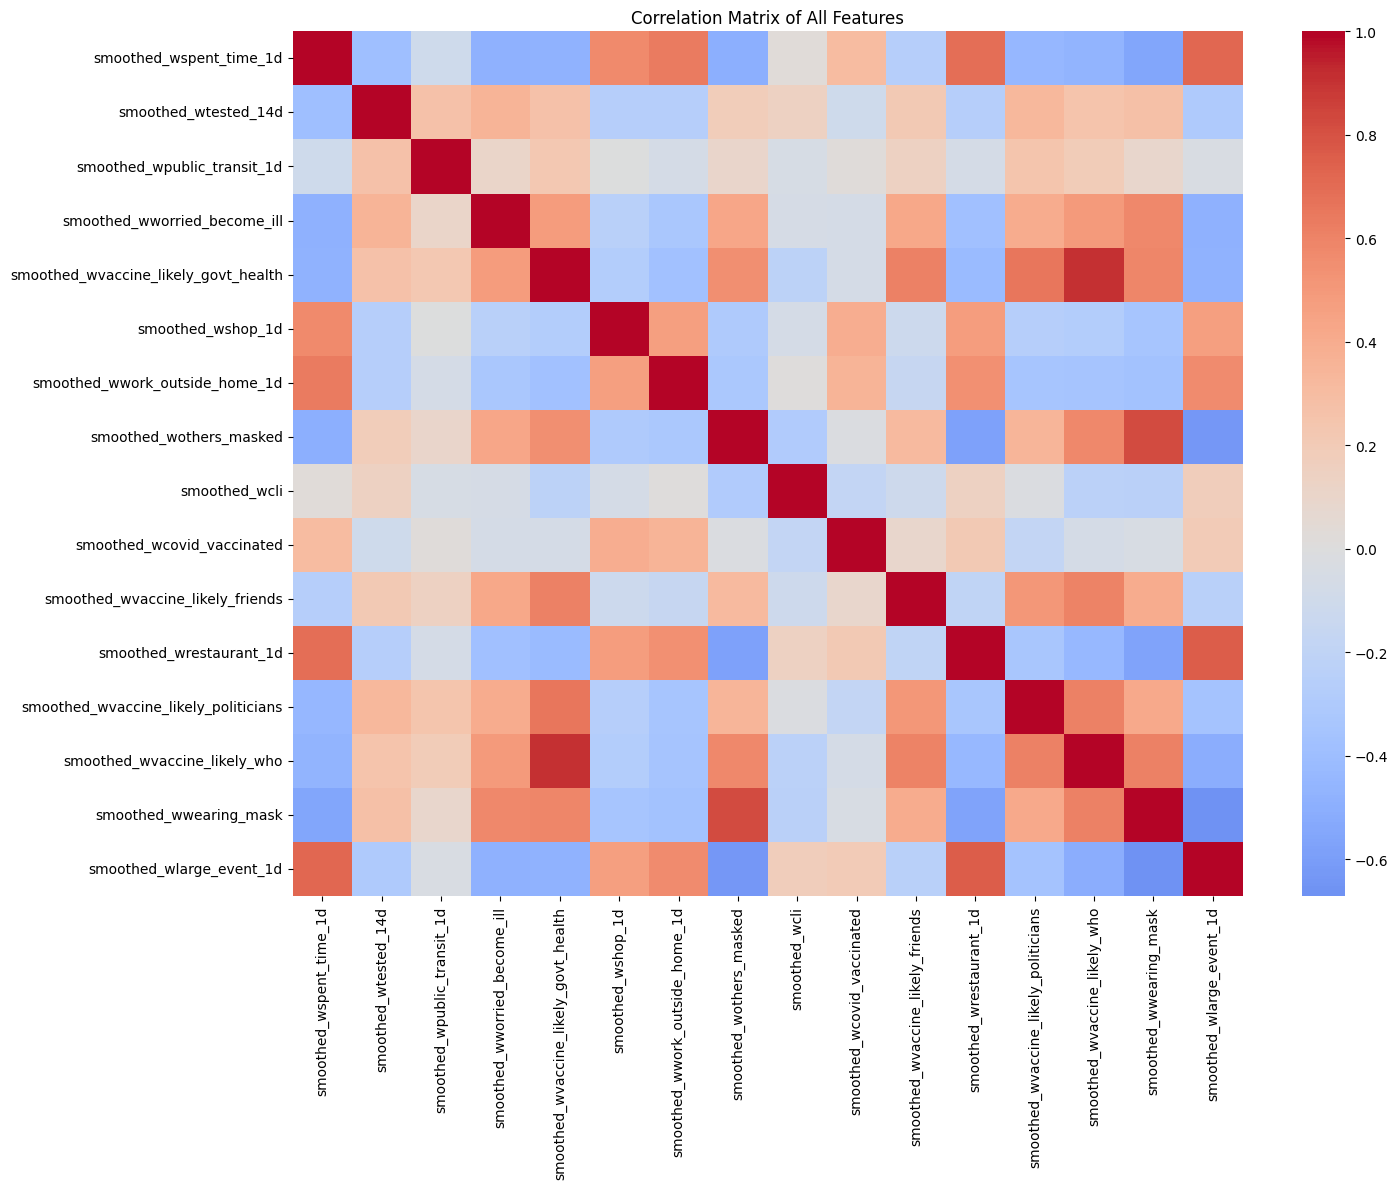

In [ ]:
# Create correlation matrix
corr_matrix = df_imputed.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.show()

In [ ]:
corrs_vaccine = df_imputed.corr(numeric_only=True)['smoothed_wcovid_vaccinated'].drop('smoothed_wcovid_vaccinated')
corrs_vaccine = corrs_vaccine.sort_values(ascending=False)

print("Feature correlations with vaccination rate:\n")
print(corrs_vaccine)

Feature correlations with vaccination rate:

smoothed_wshop_1d                       0.396846
smoothed_wwork_outside_home_1d          0.359015
smoothed_wspent_time_1d                 0.308041
smoothed_wrestaurant_1d                 0.215985
smoothed_wlarge_event_1d                0.199850
smoothed_wvaccine_likely_friends        0.090401
smoothed_wpublic_transit_1d             0.020133
smoothed_wothers_masked                -0.024365
smoothed_wwearing_mask                 -0.041569
smoothed_wvaccine_likely_govt_health   -0.067263
smoothed_wworried_become_ill           -0.069301
smoothed_wvaccine_likely_who           -0.069318
smoothed_wtested_14d                   -0.108362
smoothed_wvaccine_likely_politicians   -0.176382
smoothed_wcli                          -0.180659
Name: smoothed_wcovid_vaccinated, dtype: float64


In [ ]:
corrs_vaccine.shape
type(corrs_vaccine)

pandas.core.series.Series

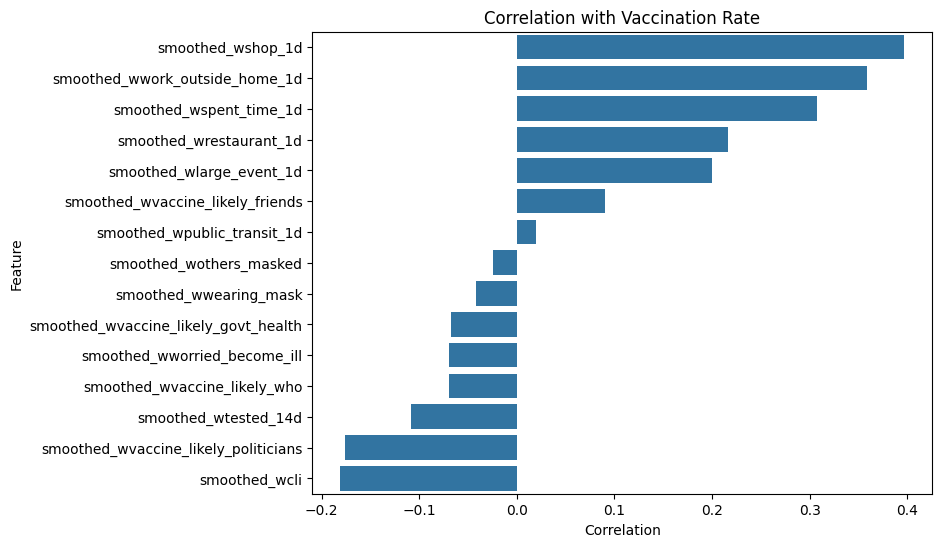

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(y=corrs_vaccine.index, x=corrs_vaccine.values)
plt.title("Correlation with Vaccination Rate")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

#### Checking for Multicolinearity

In [ ]:
# Check for multicollinearity among selected features for each target
def plot_multicollinearity(dataframe, features, title):
    corr_subset = dataframe[features].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title(f'Correlation Matrix for {title} Selected Features')
    plt.tight_layout()
    plt.show()

In [ ]:
top_cols = corrs_vaccine.index[:7].to_list()
print(top_cols + ['smoothed_wcovid_vaccinated'])

['smoothed_wshop_1d', 'smoothed_wwork_outside_home_1d', 'smoothed_wspent_time_1d', 'smoothed_wrestaurant_1d', 'smoothed_wlarge_event_1d', 'smoothed_wvaccine_likely_friends', 'smoothed_wpublic_transit_1d', 'smoothed_wcovid_vaccinated']



Checking multicollinearity for vaccine uptake prediction features:


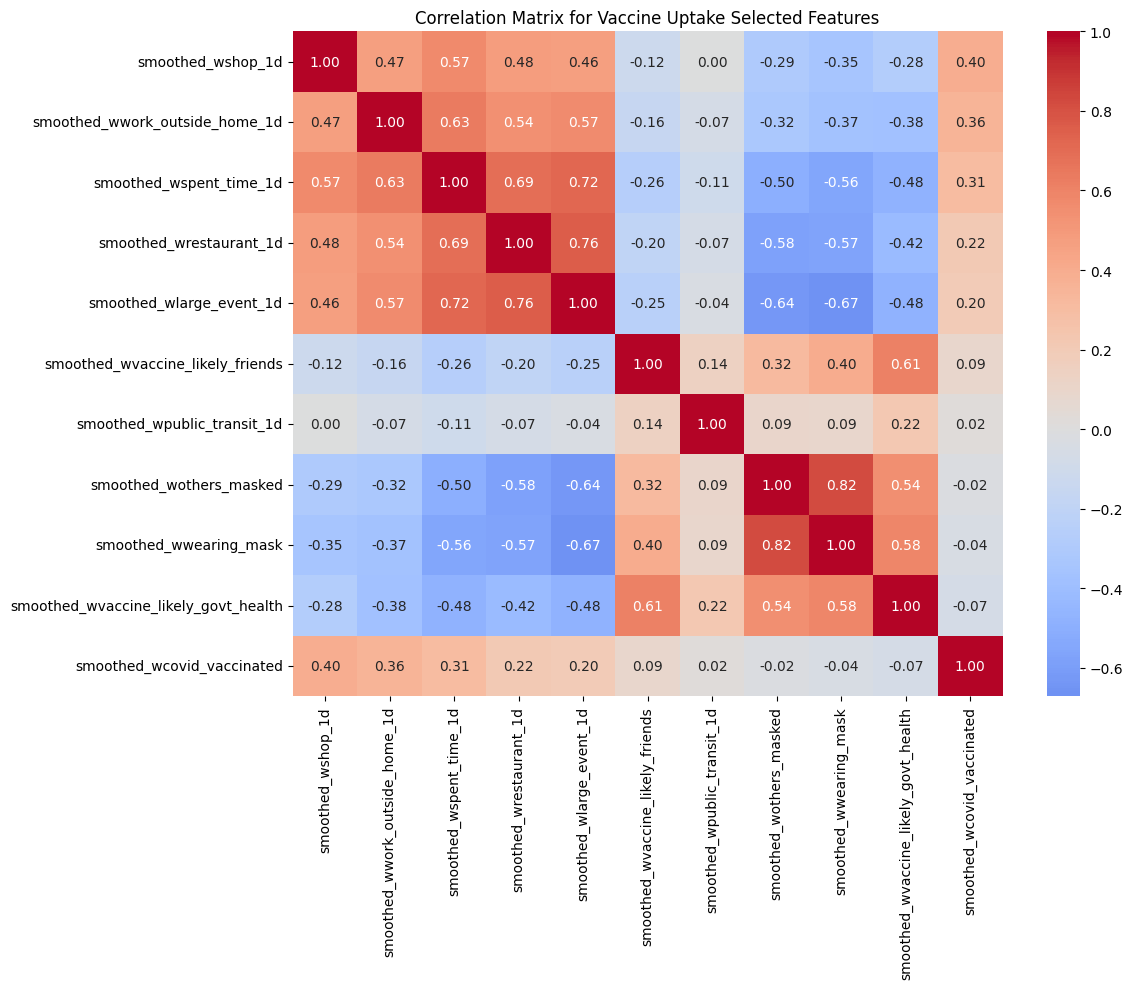

In [ ]:
# Check multicollinearity for vaccine uptake features
print("\nChecking multicollinearity for vaccine uptake prediction features:")
plot_multicollinearity(df_imputed, corrs_vaccine.index[:10].to_list() + ['smoothed_wcovid_vaccinated'], 'Vaccine Uptake')

#### Feature Extraction

In [ ]:
df_imputed.head()

,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wothers_masked,smoothed_wcli,smoothed_wcovid_vaccinated,smoothed_wvaccine_likely_friends,smoothed_wrestaurant_1d,smoothed_wvaccine_likely_politicians,smoothed_wvaccine_likely_who,smoothed_wwearing_mask,smoothed_wlarge_event_1d
0,34.412959,12.541558,1.464798,65.771681,22.086274,52.854667,30.487852,57.334785,3.244379,2.638200,28.469582,18.571266,9.482316,24.962112,84.311759,12.627098
1,30.638160,12.870745,2.445367,68.008846,28.790272,51.659913,31.177214,77.740185,1.111606,3.387556,35.582702,12.991119,14.062363,33.223929,93.845085,6.846556
2,29.160664,13.412620,2.271063,71.210935,30.085860,50.860689,27.765738,82.678038,1.971449,5.099051,29.795196,14.577687,8.449474,32.389238,94.620210,7.432713
3,38.090631,18.703121,1.829732,67.873009,25.458298,55.208924,35.789059,62.702180,2.328204,9.094108,34.200509,19.452880,11.221535,28.953169,88.328707,11.059883
4,31.031930,23.187988,5.247612,54.332976,31.829591,52.948188,31.242179,65.756589,0.421245,15.910167,29.240819,13.132258,10.050320,33.168119,82.025101,9.231545


In [ ]:
df_vaccine_cleaned = df_imputed[corrs_vaccine.index[:10].to_list() + ['smoothed_wcovid_vaccinated']]
df_vaccine_cleaned.head()

,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wspent_time_1d,smoothed_wrestaurant_1d,smoothed_wlarge_event_1d,smoothed_wvaccine_likely_friends,smoothed_wpublic_transit_1d,smoothed_wothers_masked,smoothed_wwearing_mask,smoothed_wvaccine_likely_govt_health,smoothed_wcovid_vaccinated
0,52.854667,30.487852,34.412959,18.571266,12.627098,28.469582,1.464798,57.334785,84.311759,22.086274,2.638200
1,51.659913,31.177214,30.638160,12.991119,6.846556,35.582702,2.445367,77.740185,93.845085,28.790272,3.387556
2,50.860689,27.765738,29.160664,14.577687,7.432713,29.795196,2.271063,82.678038,94.620210,30.085860,5.099051
3,55.208924,35.789059,38.090631,19.452880,11.059883,34.200509,1.829732,62.702180,88.328707,25.458298,9.094108
4,52.948188,31.242179,31.031930,13.132258,9.231545,29.240819,5.247612,65.756589,82.025101,31.829591,15.910167


In [ ]:
df_vaccine_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23024 entries, 0 to 23023
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   smoothed_wshop_1d                     23024 non-null  float64
 1   smoothed_wwork_outside_home_1d        23024 non-null  float64
 2   smoothed_wspent_time_1d               23024 non-null  float64
 3   smoothed_wrestaurant_1d               23024 non-null  float64
 4   smoothed_wlarge_event_1d              23024 non-null  float64
 5   smoothed_wvaccine_likely_friends      23024 non-null  float64
 6   smoothed_wpublic_transit_1d           23024 non-null  float64
 7   smoothed_wothers_masked               23024 non-null  float64
 8   smoothed_wwearing_mask                23024 non-null  float64
 9   smoothed_wvaccine_likely_govt_health  23024 non-null  float64
 10  smoothed_wcovid_vaccinated            23024 non-null  float64
dtypes: float64(11)


### Split the data into features and target variable

In [ ]:
target_col = 'smoothed_wcovid_vaccinated'
feature_cols = [col for col in df_vaccine_cleaned.columns if col != target_col]

In [ ]:
print("\n=== Features and Target ===")
print(f"Features: {feature_cols}")
print(f"Target: {target_col}")


=== Features and Target ===
Features: ['smoothed_wshop_1d', 'smoothed_wwork_outside_home_1d', 'smoothed_wspent_time_1d', 'smoothed_wrestaurant_1d', 'smoothed_wlarge_event_1d', 'smoothed_wvaccine_likely_friends', 'smoothed_wpublic_transit_1d', 'smoothed_wothers_masked', 'smoothed_wwearing_mask', 'smoothed_wvaccine_likely_govt_health']
Target: smoothed_wcovid_vaccinated


In [ ]:
X = df_vaccine_cleaned[feature_cols]
y = df_vaccine_cleaned[target_col]

In [ ]:
X.head()

,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,smoothed_wspent_time_1d,smoothed_wrestaurant_1d,smoothed_wlarge_event_1d,smoothed_wvaccine_likely_friends,smoothed_wpublic_transit_1d,smoothed_wothers_masked,smoothed_wwearing_mask,smoothed_wvaccine_likely_govt_health
0,52.854667,30.487852,34.412959,18.571266,12.627098,28.469582,1.464798,57.334785,84.311759,22.086274
1,51.659913,31.177214,30.638160,12.991119,6.846556,35.582702,2.445367,77.740185,93.845085,28.790272
2,50.860689,27.765738,29.160664,14.577687,7.432713,29.795196,2.271063,82.678038,94.620210,30.085860
3,55.208924,35.789059,38.090631,19.452880,11.059883,34.200509,1.829732,62.702180,88.328707,25.458298
4,52.948188,31.242179,31.031930,13.132258,9.231545,29.240819,5.247612,65.756589,82.025101,31.829591


In [ ]:
y.head()

0     2.638200
1     3.387556
2     5.099051
3     9.094108
4    15.910167
Name: smoothed_wcovid_vaccinated, dtype: float64

In [ ]:
X_train_val, X_test, y_train_val, y_test 	= train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val 				= train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is ~15% of overall

In [ ]:
print("\n=== Data Splitting ===")
print(f"Training set size: 		{X_train.shape[0]} 		samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set size: 		{X_val.shape[0]} 		samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set size: 			{X_test.shape[0]} 		samples ({X_test.shape[0]/len(X):.1%})")


=== Data Splitting ===
Training set size: 		16115 		samples (70.0%)
Validation set size: 		3455 		samples (15.0%)
Test set size: 			3454 		samples (15.0%)


### Scaling the data

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled 		= scaler.transform(X_train)
X_val_scaled 		= scaler.transform(X_val)
X_test_scaled 		= scaler.transform(X_test)

### Define Evaluation Functions

In [ ]:
# 5. Define a function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred 	= model.predict(X_train)
    y_val_pred 		= model.predict(X_val)

    # Calculate metrics
    train_rmse 		= np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse 		= np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_mae 		= mean_absolute_error(y_train, y_train_pred)
    val_mae 		= mean_absolute_error(y_val, y_val_pred)

    train_r2 		= r2_score(y_train, y_train_pred)
    val_r2 			= r2_score(y_val, y_val_pred)

    results = {
        'train_rmse': 	train_rmse,
        'val_rmse': 	val_rmse,
        'train_mae': 	train_mae,
        'val_mae': 		val_mae,
        'train_r2': 	train_r2,
        'val_r2': 		val_r2
    }

    return results

In [ ]:
# 6. Perform K-fold cross-validation - FIXED FUNCTION
def perform_cross_validation(model, X, y, k=5):
    # Convert X and y to numpy arrays if they are pandas DataFrame/Series
    if isinstance(X, pd.DataFrame):
        X_array = X.values
    else:
        X_array = X

    if isinstance(y, pd.Series):
        y_array = y.values
    else:
        y_array = y

    kf 			= KFold(n_splits=k, shuffle=True, random_state=42)

    # Metrics to evaluate
    rmse_scores 	= []
    mae_scores 		= []
    r2_scores 		= []

    for train_index, val_index in kf.split(X_array):
        # Now using numpy array indexing which works correctly
        X_train_cv, X_val_cv 	= X_array[train_index], X_array[val_index]
        y_train_cv, y_val_cv 	= y_array[train_index], y_array[val_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)

        # Make predictions
        y_val_pred_cv 			= model.predict(X_val_cv)

        # Calculate metrics
        rmse 		= np.sqrt(mean_squared_error(y_val_cv, y_val_pred_cv))
        mae 		= mean_absolute_error(y_val_cv, y_val_pred_cv)
        r2 			= r2_score(y_val_cv, y_val_pred_cv)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    cv_results = {
        'rmse_mean': 	np.mean(rmse_scores),
        'rmse_std': 	np.std(rmse_scores),
        'mae_mean': 	np.mean(mae_scores),
        'mae_std': 		np.std(mae_scores),
        'r2_mean': 		np.mean(r2_scores),
        'r2_std': 		np.std(r2_scores)
    }

    return cv_results

In [ ]:
def perform_grid_search(model, params, X_train, y_train, cv=5, scoring='r2'):
    grid_search = GridSearchCV(
        model,
        param_grid=params,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters:    {grid_search.best_params_}")
    print(f"Best R² score:        {grid_search.best_score_}")

    best_model = grid_search.best_estimator_

    return best_model

In [ ]:
model_results = {}
cv_results_all = {}

### Model Evaluations

#### Model 1: Linear Regression

In [ ]:
param_grid_linear = {
    'fit_intercept': 	[True, False],
    'positive': 		[True, False]  # Constrain coefficients to be positive
}

In [ ]:
print("--- Baseline Model: Linear Regression ---\n")
best_lr_model = perform_grid_search(LinearRegression(), param_grid_linear, X_train_scaled, y_train)
best_lr_model

--- Baseline Model: Linear Regression ---

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters:    {'fit_intercept': True, 'positive': False}
Best R² score:        0.2402792512866058


LinearRegression()

In [ ]:
# evaluate using best model found in grid search
lr_results = evaluate_model(best_lr_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Linear Regression'] = lr_results

In [ ]:
# Cross-validation for Linear Regression
lr_cv_results = perform_cross_validation(best_lr_model, X_train_scaled, y_train)
cv_results_all['Linear Regression'] = lr_cv_results

In [ ]:
print(f"Train RMSE: 			{lr_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{lr_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{lr_results['train_mae']:.4f}")
print(f"Validation MAE: 		{lr_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{lr_results['train_r2']:.4f}")
print(f"Validation R²: 			{lr_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{lr_cv_results['rmse_mean']:.4f} ± {lr_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{lr_cv_results['mae_mean']:.4f} ± {lr_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{lr_cv_results['r2_mean']:.4f} ± {lr_cv_results['r2_std']:.4f}")

Train RMSE: 			5.8069
Validation RMSE: 		5.8301

Train MAE: 			4.5477
Validation MAE: 		4.5538

Train R²: 			0.2418
Validation R²: 			0.2259

Cross-Validation RMSE: 		5.8118 ± 0.0564
Cross-Validation MAE: 		4.5513 ± 0.0481
Cross-Validation R²: 		0.2401 ± 0.0089


In [ ]:
# Feature importance for Linear Regression
print("\nFeature importances (coefficient magnitudes):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_lr_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)


Feature importances (coefficient magnitudes):
                                Feature  Importance
0                     smoothed_wshop_1d    1.967951
1        smoothed_wwork_outside_home_1d    1.529052
5      smoothed_wvaccine_likely_friends    1.008032
2               smoothed_wspent_time_1d    0.827711
8                smoothed_wwearing_mask    0.817122
7               smoothed_wothers_masked    0.381598
9  smoothed_wvaccine_likely_govt_health    0.308710
6           smoothed_wpublic_transit_1d    0.146320
3               smoothed_wrestaurant_1d    0.116032
4              smoothed_wlarge_event_1d    0.018752


#### Model 2: Ridge Regression (L2 Regularization)

In [ ]:
param_grid_ridge = {
    'alpha': np.logspace(-4, 2, 20),  # Testing alpha from 0.0001 to 100
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [ ]:
print("--- Ridge Regression ---\n")
best_ridge_model = perform_grid_search(Ridge(), param_grid_ridge, X_train_scaled, y_train)
best_ridge_model

In [ ]:
# evaluate using best model found in grid search
ridge_results = evaluate_model(best_ridge_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Ridge Regression'] = ridge_results

In [ ]:
# Cross-validation for Ridge Regression
ridge_cv_results = perform_cross_validation(best_ridge_model, X_train_scaled, y_train)
cv_results_all['Ridge Regression'] = ridge_cv_results

In [ ]:
grid_search_ridge = GridSearchCV(
    Ridge(),
    param_grid=param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='r2', verbose=1)

In [ ]:
print("Best parameters for Ridge Regression:", grid_search_ridge.best_params_)
print("Best R² score:", grid_search_ridge.best_score_)

Best parameters for Ridge Regression: {'alpha': 100.0, 'fit_intercept': True, 'solver': 'saga'}
Best R² score: 0.240297439002864


In [ ]:
best_ridge_model = grid_search_ridge.best_estimator_
best_ridge_model

Ridge(alpha=100.0, solver='saga')

In [ ]:
ridge_results = evaluate_model(best_ridge_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Ridge Regression'] = ridge_results

In [ ]:
ridge_cv_results = perform_cross_validation(best_ridge_model, X_train_scaled, y_train)
cv_results_all['Ridge Regression'] = ridge_cv_results

In [ ]:
print(f"Train RMSE: 			{ridge_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{ridge_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{ridge_results['train_mae']:.4f}")
print(f"Validation MAE: 		{ridge_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{ridge_results['train_r2']:.4f}")
print(f"Validation R²: 			{ridge_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{ridge_cv_results['rmse_mean']:.4f} ± {ridge_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{ridge_cv_results['mae_mean']:.4f} ± {ridge_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{ridge_cv_results['r2_mean']:.4f} ± {ridge_cv_results['r2_std']:.4f}")

Train RMSE: 			5.8070
Validation RMSE: 		5.8299

Train MAE: 			4.5487
Validation MAE: 		4.5547

Train R²: 			0.2418
Validation R²: 			0.2260

Cross-Validation RMSE: 		5.8117 ± 0.0566
Cross-Validation MAE: 		4.5526 ± 0.0481
Cross-Validation R²: 		0.2401 ± 0.0088


In [ ]:
# Feature importance for Ridge (shows feature selection)
print("\nFeature importances (non-zero coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_ridge_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance[feature_importance['Importance'] > 0])

#### Model 3: Lasso Regression (L1 Regularization)

In [ ]:
param_grid_lasso = {
    'alpha': np.logspace(-4, 0, 20),  # Testing alpha from 0.0001 to 1
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random'],
    'max_iter': [10000],  # Increase max iterations to ensure convergence
    'tol': [1e-4]
}

In [ ]:
print("--- Lasso Regression ---\n")
best_lasso_model = perform_grid_search(Lasso(), param_grid_lasso, X_train_scaled, y_train)
best_lasso_model

--- Lasso Regression ---

Fitting 5 folds for each of 80 candidates, totalling 400 fits

Best parameters:    {'alpha': 0.0006951927961775605, 'fit_intercept': True, 'max_iter': 10000, 'selection': 'random', 'tol': 0.0001}
Best R² score:        0.24027962258513869


Lasso(alpha=0.0006951927961775605, max_iter=10000, selection='random')

In [ ]:
# evaluate using best model found in grid search
lasso_results = evaluate_model(best_lasso_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Lasso Regression'] = lasso_results

In [ ]:
# Cross-validation for Lasso Regression
lasso_cv_results = perform_cross_validation(best_lasso_model, X_train_scaled, y_train)
cv_results_all['Lasso Regression'] = lasso_cv_results

In [ ]:
print(f"Train RMSE: 			{lasso_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{lasso_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{lasso_results['train_mae']:.4f}")
print(f"Validation MAE: 		{lasso_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{lasso_results['train_r2']:.4f}")
print(f"Validation R²: 			{lasso_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{lasso_cv_results['rmse_mean']:.4f} ± {lasso_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{lasso_cv_results['mae_mean']:.4f} ± {lasso_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{lasso_cv_results['r2_mean']:.4f} ± {lasso_cv_results['r2_std']:.4f}")

Train RMSE: 			5.8069
Validation RMSE: 		5.8302

Train MAE: 			4.5477
Validation MAE: 		4.5539

Train R²: 			0.2418
Validation R²: 			0.2259

Cross-Validation RMSE: 		5.8118 ± 0.0564
Cross-Validation MAE: 		4.5514 ± 0.0481
Cross-Validation R²: 		0.2401 ± 0.0089


In [ ]:
# Feature importance for Lasso (shows feature selection)
print("\nFeature importances (non-zero coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_lasso_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance[feature_importance['Importance'] > 0])


Feature importances (non-zero coefficients):
                                Feature  Importance
0                     smoothed_wshop_1d    1.967422
1        smoothed_wwork_outside_home_1d    1.528478
5      smoothed_wvaccine_likely_friends    1.006193
2               smoothed_wspent_time_1d    0.825358
8                smoothed_wwearing_mask    0.816190
7               smoothed_wothers_masked    0.381501
9  smoothed_wvaccine_likely_govt_health    0.305947
6           smoothed_wpublic_transit_1d    0.145255
3               smoothed_wrestaurant_1d    0.114470
4              smoothed_wlarge_event_1d    0.016802


#### Model 4: Decision Tree Regressor

In [ ]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

In [ ]:
print("--- Decision Tree Regressor ---\n")
best_dt_model = perform_grid_search(DecisionTreeRegressor(random_state=42), param_grid_dt, X_train_scaled, y_train)
best_dt_model

--- Decision Tree Regressor ---

Fitting 5 folds for each of 960 candidates, totalling 4800 fits

Best parameters:    {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best R² score:        0.2595928587538664


/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3200 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
178 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/kavisarna/Programming/Conda/miniconda3/e

DecisionTreeRegressor(criterion='friedman_mse', max_depth=7, max_features=0.7,
                      min_samples_split=10, random_state=42)

In [ ]:
# evaluate using best model found in grid search
dt_results = evaluate_model(best_dt_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Decision Tree'] = dt_results

In [ ]:
# Cross-validation for Decision Tree
dt_cv_results = perform_cross_validation(best_dt_model, X_train_scaled, y_train)
cv_results_all['Decision Tree'] = dt_cv_results

In [ ]:
print(f"Train RMSE: 			{dt_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{dt_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{dt_results['train_mae']:.4f}")
print(f"Validation MAE: 		{dt_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{dt_results['train_r2']:.4f}")
print(f"Validation R²: 			{dt_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{dt_cv_results['rmse_mean']:.4f} ± {dt_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{dt_cv_results['mae_mean']:.4f} ± {dt_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{dt_cv_results['r2_mean']:.4f} ± {dt_cv_results['r2_std']:.4f}")

Train RMSE: 			5.3934
Validation RMSE: 		5.7497

Train MAE: 			4.1814
Validation MAE: 		4.4234

Train R²: 			0.3459
Validation R²: 			0.2471

Cross-Validation RMSE: 		5.7530 ± 0.0887
Cross-Validation MAE: 		4.4643 ± 0.0472
Cross-Validation R²: 		0.2555 ± 0.0080


In [ ]:
# Feature importance for Decision Trees (shows feature selection)
print("\nFeature importances (non-zero coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_dt_model.feature_importances_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance[feature_importance['Importance'] > 0])


Feature importances (non-zero coefficients):
                                Feature  Importance
0                     smoothed_wshop_1d    0.456521
1        smoothed_wwork_outside_home_1d    0.178113
9  smoothed_wvaccine_likely_govt_health    0.086926
7               smoothed_wothers_masked    0.082648
5      smoothed_wvaccine_likely_friends    0.075716
8                smoothed_wwearing_mask    0.048990
2               smoothed_wspent_time_1d    0.030438
3               smoothed_wrestaurant_1d    0.023180
6           smoothed_wpublic_transit_1d    0.011627
4              smoothed_wlarge_event_1d    0.005842


#### Model 5: Random Forest Regressor

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [ ]:
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=1)

In [ ]:
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best R² score:", grid_search_rf.best_score_)

Best parameters for Random Forest: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best R² score: 0.457254972698833


In [ ]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      n_estimators=300, random_state=42)

In [ ]:
rf_results = evaluate_model(best_rf_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Random Forest'] = rf_results

In [ ]:
rf_cv_results = perform_cross_validation(best_rf_model, X_train_scaled, y_train)
cv_results_all['Random Forest'] = rf_cv_results

In [ ]:
print(f"Train RMSE: 			{rf_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{rf_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{rf_results['train_mae']:.4f}")
print(f"Validation MAE: 		{rf_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{rf_results['train_r2']:.4f}")
print(f"Validation R²: 			{rf_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{rf_cv_results['rmse_mean']:.4f} ± {rf_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{rf_cv_results['mae_mean']:.4f} ± {rf_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{rf_cv_results['r2_mean']:.4f} ± {rf_cv_results['r2_std']:.4f}")

Train RMSE: 			0.9783
Validation RMSE: 		4.8789

Train MAE: 			0.5484
Validation MAE: 		3.6775

Train R²: 			0.9785
Validation R²: 			0.4579

Cross-Validation RMSE: 		4.9221 ± 0.0798
Cross-Validation MAE: 		3.7371 ± 0.0498
Cross-Validation R²: 		0.4550 ± 0.0033


#### Model 6: Gradient Boosting Regresssor

In [ ]:
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_gb.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='r2', verbose=1)

In [ ]:
print("Best parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best R² score:", grid_search_gb.best_score_)

Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.9}
Best R² score: 0.4541485851099877


In [ ]:
best_gb_model = grid_search_gb.best_estimator_
best_gb_model

GradientBoostingRegressor(learning_rate=0.05, max_depth=9, max_features='sqrt',
                          min_samples_leaf=2, n_estimators=300, random_state=42,
                          subsample=0.9)

In [ ]:
gb_results = evaluate_model(best_gb_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['Gradient Boosting'] = gb_results

In [ ]:
gb_cv_results = perform_cross_validation(best_gb_model, X_train_scaled, y_train)
cv_results_all['Gradient Boosting'] = gb_cv_results

In [ ]:
print(f"Train RMSE: 			{gb_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{gb_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{gb_results['train_mae']:.4f}")
print(f"Validation MAE: 		{gb_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{gb_results['train_r2']:.4f}")
print(f"Validation R²: 			{gb_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{gb_cv_results['rmse_mean']:.4f} ± {gb_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{gb_cv_results['mae_mean']:.4f} ± {gb_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{gb_cv_results['r2_mean']:.4f} ± {gb_cv_results['r2_std']:.4f}")

Train RMSE: 			2.4296
Validation RMSE: 		4.9194

Train MAE: 			1.7941
Validation MAE: 		3.7636

Train R²: 			0.8673
Validation R²: 			0.4489

Cross-Validation RMSE: 		4.9320 ± 0.0532
Cross-Validation MAE: 		3.7730 ± 0.0368
Cross-Validation R²: 		0.4528 ± 0.0038


In [ ]:
# Feature importance for Gradient Boosting (shows feature selection)
print("\nFeature importances (non-zero coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_gb_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance[feature_importance['Importance'] > 0])


Feature importances (non-zero coefficients):


AttributeError: 'GradientBoostingRegressor' object has no attribute 'coef_'

#### Model 7: Support Vector Regressor

In [ ]:
from sklearn.svm import SVR

In [ ]:
param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'epsilon': [0.01, 0.1, 0.2],
    'shrinking': [True, False]
}

In [ ]:
grid_search_svr = GridSearchCV(
    SVR(),
    param_grid=param_grid_svr,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_svr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.2],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'shrinking': [True, False]},
             scoring='r2', verbose=1)

In [ ]:
print("Best parameters for SVR:", grid_search_svr.best_params_)
print("Best R² score:", grid_search_svr.best_score_)

Best parameters for SVR: {'C': 100, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': False}
Best R² score: 0.3766608408802387


In [ ]:
best_svr_model = grid_search_svr.best_estimator_
best_svr_model

SVR(C=100, epsilon=0.2, gamma='auto', shrinking=False)

In [ ]:
# evaluate using best model found in grid search
svr_results = evaluate_model(best_svr_model, X_train_scaled, X_val_scaled, y_train, y_val)
model_results['SVR'] = svr_results

In [ ]:
# Cross-validation for SVR
svr_cv_results = perform_cross_validation(best_svr_model, X_train_scaled, y_train)
cv_results_all['SVR'] = svr_cv_results

In [ ]:
print(f"Train RMSE: 			{svr_results['train_rmse']:.4f}")
print(f"Validation RMSE: 		{svr_results['val_rmse']:.4f}")
print()
print(f"Train MAE: 			{svr_results['train_mae']:.4f}")
print(f"Validation MAE: 		{svr_results['val_mae']:.4f}")
print()
print(f"Train R²: 			{svr_results['train_r2']:.4f}")
print(f"Validation R²: 			{svr_results['val_r2']:.4f}")
print()
print(f"Cross-Validation RMSE: 		{svr_cv_results['rmse_mean']:.4f} ± {svr_cv_results['rmse_std']:.4f}")
print(f"Cross-Validation MAE: 		{svr_cv_results['mae_mean']:.4f} ± {svr_cv_results['mae_std']:.4f}")
print(f"Cross-Validation R²: 		{svr_cv_results['r2_mean']:.4f} ± {svr_cv_results['r2_std']:.4f}")

Train RMSE: 			4.7102
Validation RMSE: 		5.2819

Train MAE: 			3.2291
Validation MAE: 		3.8501

Train R²: 			0.5012
Validation R²: 			0.3647

Cross-Validation RMSE: 		5.2781 ± 0.0788
Cross-Validation MAE: 		3.8816 ± 0.0394
Cross-Validation R²: 		0.3732 ± 0.0150


In [ ]:
# Feature importance for SVR (shows feature selection)
print("\nFeature importances (non-zero coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(best_svr_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance[feature_importance['Importance'] > 0])


Feature importances (non-zero coefficients):


AttributeError: coef_ is only available when using a linear kernel

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
permutation_result = permutation_importance(
    best_svr_model, X_test, y_test,
    n_repeats=5,
    random_state=42
)

/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/Users/kavisarna/Programming/Conda/miniconda3/envs/MLIP/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': permutation_result.importances_mean
})

# Sort and display
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

,Feature,Importance
0,smoothed_wshop_1d,0.0
1,smoothed_wwork_outside_home_1d,0.0
2,smoothed_wspent_time_1d,0.0
3,smoothed_wrestaurant_1d,0.0
4,smoothed_wlarge_event_1d,0.0
5,smoothed_wvaccine_likely_friends,0.0
6,smoothed_wpublic_transit_1d,0.0
7,smoothed_wothers_masked,0.0
8,smoothed_wwearing_mask,0.0
9,smoothed_wvaccine_likely_govt_health,0.0


### Model Comparison

In [ ]:
print("=== Model Comparison ===")

# Create a DataFrame for model comparison
model_comparison = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Validation RMSE': [results['val_rmse'] for results in model_results.values()],
    'Validation MAE': [results['val_mae'] for results in model_results.values()],
    'Validation R²': [results['val_r2'] for results in model_results.values()],
    'Cross-Val RMSE': [cv_results_all[model]['rmse_mean'] for model in model_results.keys()],
    'Cross-Val MAE': [cv_results_all[model]['mae_mean'] for model in model_results.keys()],
    'Cross-Val R²': [cv_results_all[model]['r2_mean'] for model in model_results.keys()]
})

=== Model Comparison ===


In [ ]:
model_comparison = model_comparison.sort_values('Validation RMSE')
model_comparison

,Model,Validation RMSE,Validation MAE,Validation R²,Cross-Val RMSE,Cross-Val MAE,Cross-Val R²
4,Random Forest,4.878888,3.677458,0.457916,4.922126,3.737063,0.455040
5,Gradient Boosting,4.919422,3.763614,0.448871,4.932021,3.772985,0.452763
6,SVR,5.281918,3.850054,0.364657,5.278120,3.881618,0.373167
3,Decision Tree,5.749679,4.423414,0.247144,5.752983,4.464340,0.255486
1,Ridge Regression,5.829931,4.554750,0.225981,5.811697,4.552607,0.240095
0,Linear Regression,5.830124,4.553819,0.225929,5.811753,4.551312,0.240079
2,Lasso Regression,5.830196,4.553933,0.225910,5.811752,4.551400,0.240079


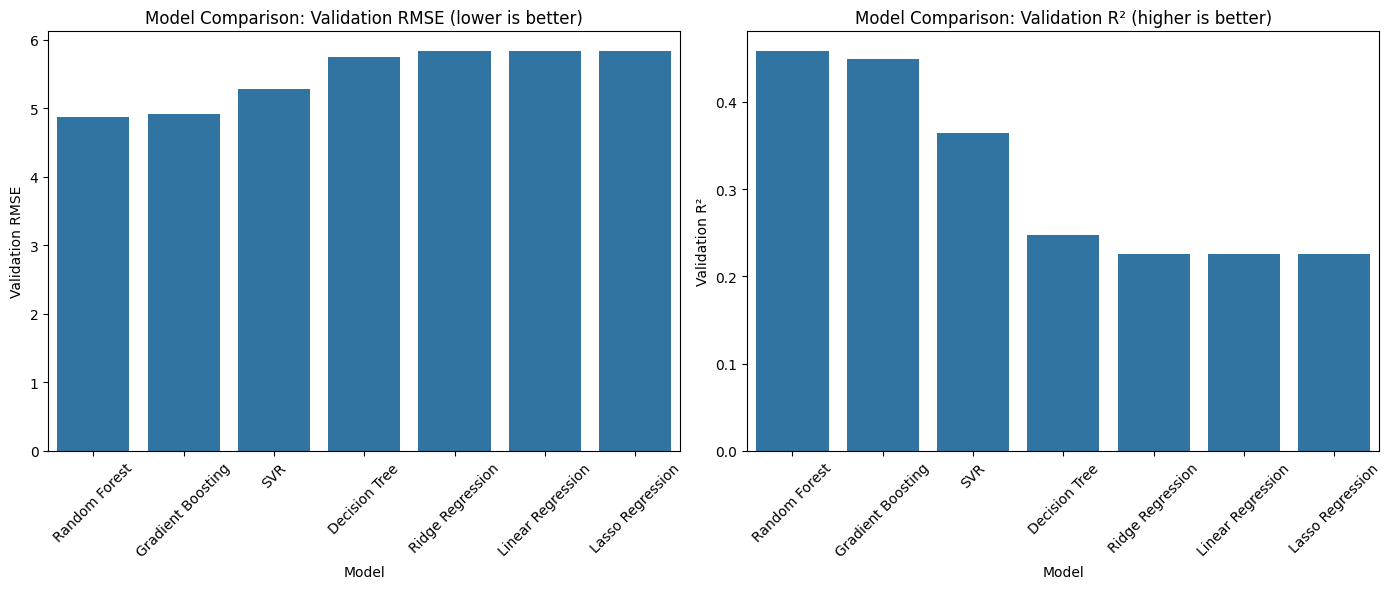

In [ ]:
# Visualize model performance
plt.figure(figsize=(14, 6))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Validation RMSE', data=model_comparison)
plt.title('Model Comparison: Validation RMSE (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()

# R² comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Validation R²', data=model_comparison)
plt.title('Model Comparison: Validation R² (higher is better)')
plt.xticks(rotation=45)
plt.tight_layout()

# plt.savefig('model_comparison.png')
plt.show()

In [ ]:
# 9. Evaluate Best Model on Test Set
print("\n=== Best Model Evaluation on Test Set ===")

# Identify the best model
best_model_name = model_comparison.iloc[0]['Model']
print(f"Best model: {best_model_name}")


=== Best Model Evaluation on Test Set ===
Best model: Random Forest


In [ ]:
# Select the corresponding model
if best_model_name == 'Linear Regression':
    best_model = best_lr_model
elif best_model_name == 'Ridge Regression':
    best_model = best_ridge_model
elif best_model_name == 'Lasso Regression':
    best_model = best_lasso_model
elif best_model_name == 'Decision Tree':
    best_model = best_dt_model
elif best_model_name == 'Random Forest':
    best_model = best_rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = best_gb_model
elif best_model_name == 'SVR':
    best_model = best_svr_model

In [ ]:
# Evaluate on test set
y_test_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [ ]:
print(f"Test RMSE: 	{test_rmse:.4f}")
print(f"Test MAE: 	{test_mae:.4f}")
print(f"Test R²: 	{test_r2:.4f}")

Test RMSE: 	4.7552
Test MAE: 	3.6066
Test R²: 	0.4945


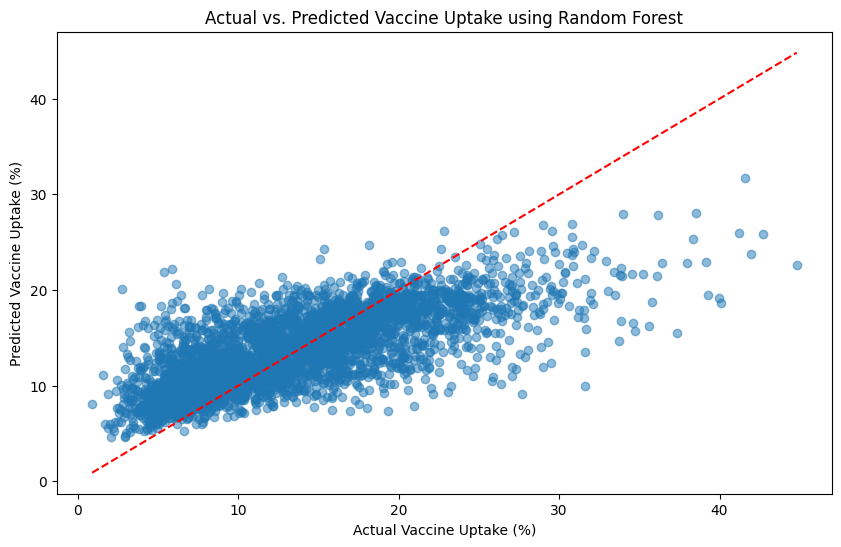

In [ ]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Vaccine Uptake (%)')
plt.ylabel('Predicted Vaccine Uptake (%)')
plt.title(f'Actual vs. Predicted Vaccine Uptake using {best_model_name}')
# plt.savefig('actual_vs_predicted.png')
plt.show()